In [2]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from protein_oracle.data_utils import ProteinStructureDataset, ProteinDPODataset, featurize
from torch.utils.data import DataLoader
from protein_oracle.model_utils import ProteinMPNNOracle
import torch
from tqdm import tqdm
from scipy.stats import pearsonr
import argparse
from protein_oracle.utils import str2bool
from fmif.fm_utils import Interpolant
from fmif.model_utils import ProteinMPNNFMIF

In [6]:
argparser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

argparser.add_argument("--path_for_pdbs", type=str, default="/data/wangc239/proteindpo_data/AlphaFold_model_PDBs", help="path for loading pdb files") 
argparser.add_argument("--path_for_dpo_dicts", type=str, default="/data/wangc239/proteindpo_data/processed_data", help="path for loading ProteinDPO dict files") 

# TODO: modify the outputs logging system and wandb logging
argparser.add_argument("--path_for_outputs", type=str, default="/data/wangc239/protein_oracle/outputs", help="path for logs and model weights")
argparser.add_argument("--previous_checkpoint", type=str, default="", help="path for previous model weights, e.g. file.pt")
argparser.add_argument("--num_epochs", type=int, default=100, help="number of epochs to train for") # 200
argparser.add_argument("--save_model_every_n_epochs", type=int, default=10, help="save model weights every n epochs")
# argparser.add_argument("--reload_data_every_n_epochs", type=int, default=2, help="reload training data every n epochs")
# argparser.add_argument("--num_examples_per_epoch", type=int, default=1000000, help="number of training example to load for one epoch")
argparser.add_argument("--batch_size", type=int, default=32, help="number of sequences for one batch") # 128
# argparser.add_argument("--max_protein_length", type=int, default=10000, help="maximum length of the protein complext")
argparser.add_argument("--hidden_dim", type=int, default=128, help="hidden model dimension")
argparser.add_argument("--num_encoder_layers", type=int, default=3, help="number of encoder layers") 
argparser.add_argument("--num_decoder_layers", type=int, default=3, help="number of decoder layers")
argparser.add_argument("--num_neighbors", type=int, default=30, help="number of neighbors for the sparse graph")   # 48
argparser.add_argument("--dropout", type=float, default=0.1, help="dropout level; 0.0 means no dropout") # TODO
argparser.add_argument("--backbone_noise", type=float, default=0.1, help="amount of noise added to backbone during training")   # TODO
argparser.add_argument("--rescut", type=float, default=3.5, help="PDB resolution cutoff")
argparser.add_argument("--debug", type=str2bool, default=False, help="minimal data loading for debugging")
argparser.add_argument("--gradient_norm", type=float, default=1.0, help="clip gradient norm, set to negative to omit clipping")
argparser.add_argument("--mixed_precision", type=str2bool, default=True, help="train with mixed precision")
argparser.add_argument("--initialize_with_pretrain", type=str2bool, default=False, help="initialize with FMIF weights")
argparser.add_argument("--train_using_diff", type=str2bool, default=False, help="training using difference in dG")
argparser.add_argument("--predict_ddg", type=str2bool, default=False, help="model directly predicts ddG")

argparser.add_argument("--wandb_name", type=str, default="debug", help="wandb run name")
argparser.add_argument("--lr", type=float, default=1e-4)
argparser.add_argument("--wd", type=float, default=1e-4)

argparser.add_argument("--min_t", type=float, default=1e-2)
argparser.add_argument("--schedule", type=str, default='linear') # other schedule is not implemented
argparser.add_argument("--schedule_exp_rate", type=float, default=-3)
argparser.add_argument("--temp", type=float, default=0.1)
argparser.add_argument("--noise", type=float, default=1.0) # 20.0
argparser.add_argument("--interpolant_type", type=str, default='masking')
argparser.add_argument("--do_purity", type=str2bool, default=False) # True
argparser.add_argument("--num_timesteps", type=int, default=50) # 500
argparser.add_argument("--seed", type=int, default=0)
# argparser.add_argument("--eval_every_n_epochs", type=int, default=20)

argparser.add_argument("--accum_steps", type=int, default=1)
argparser.add_argument("--truncate_steps", type=int, default=10)
argparser.add_argument("--alpha", type=float, default=0.001)
argparser.add_argument("--gumbel_softmax_temp", type=float, default=0.5)

args = argparser.parse_args([])

In [20]:
reward_model = ProteinMPNNOracle(node_features=args.hidden_dim,
                    edge_features=args.hidden_dim,
                    hidden_dim=args.hidden_dim,
                    num_encoder_layers=args.num_encoder_layers,
                    num_decoder_layers=args.num_encoder_layers,
                    k_neighbors=args.num_neighbors,
                    dropout=args.dropout,
                    # augment_eps=args.backbone_noise
                    )
reward_model.cuda()
reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/gEpAwkRkQi_20240819_144109/model_weights/epoch25_step85675.pt')['model_state_dict'])
args.predict_ddg = True
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/wxOgZgpcMg_20240816_115630/model_weights/epoch5_step17135.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/hhgQCPDZUk_20240815_094107/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/JwIadLuXUJ_20240815_094104/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/kkCCLGylbM_20240815_094106/model_weights/epoch20_step68540.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/hMPXtZStXo_20240815_094100/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/gCVVtzUeKD_20240814_215947/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/LhPfOrBbzL_20240814_215944/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/chTRlNGzKF_20240814_162228/model_weights/epoch20_step68540.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/xysQEMKzOk_20240814_162020/model_weights/epoch10_step34270.pt')['model_state_dict'])
# reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/azLcCvVyTH_20240716_172237/model_weights/epoch10_step37430.pt')['model_state_dict'])
reward_model.eval()

ProteinMPNNOracle(
  (features): ProteinFeatures(
    (embeddings): PositionalEncodings(
      (linear): Linear(in_features=66, out_features=16, bias=True)
    )
    (edge_embedding): Linear(in_features=416, out_features=128, bias=False)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (W_e): Linear(in_features=128, out_features=128, bias=True)
  (W_s): Embedding(22, 128)
  (encoder_layers): ModuleList(
    (0-2): 3 x EncLayer(
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (W1): Linear(in_features=384, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (W3): Linear(in_features=128, out_features=128, bias

### For Nisnoff et al. Testing Sequences
2JT1.pdb, 6M3N.pdb, 5KPH.pdb; all in our training set

In [5]:
pdb_path = '/data/wangc239/proteindpo_data/AlphaFold_model_PDBs'
max_len = 75  # Define the maximum length of proteins
dataset = ProteinStructureDataset(pdb_path, max_len) # max_len set to 75 (sequences range from 31 to 74)
loader = DataLoader(dataset, batch_size=1000, shuffle=False)

# make a dict of pdb filename: index
for batch in loader:
    pdb_structures = batch[0]
    pdb_filenames = batch[1]
    pdb_idx_dict = {pdb_filenames[i]: i for i in range(len(pdb_filenames))}
    break
dpo_dict_path = '/data/wangc239/proteindpo_data/processed_data'
dpo_train_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict_curated.pkl'), 'rb')) # 2388

In [10]:
def analyze_protein(name, dpo_dict=dpo_train_dict, predict_ddg=False):
    dpo_train_dict_sub = {k: v for k, v in dpo_dict.items() if v[-1] == f'{name}.pdb'}
    dpo_train_dataset = ProteinDPODataset(dpo_train_dict_sub, pdb_idx_dict, pdb_structures)
    loader_train = DataLoader(dpo_train_dataset, batch_size=128, shuffle=False)
    device = 'cuda'
    ddgs_list_pred = []
    ddgs_list_gt = []
    for batch in tqdm(loader_train):
        X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, device)
        with torch.no_grad():
            dg_pred = reward_model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
            dg_pred_wt = reward_model(X, S_wt, mask, chain_M, residue_idx, chain_encoding_all)
        if predict_ddg:
            ddgs_list_pred.extend(dg_pred.cpu().numpy())
        else:
            ddgs_list_pred.extend((dg_pred - dg_pred_wt).cpu().numpy())
        ddgs_list_gt.extend(batch['dG_ML'] - batch['dG_ML_wt'])
    
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns

    # First subplot: Boxen plot using sns.boxenplot
    plot_data = pd.DataFrame({'ddgs': np.concatenate([ddgs_list_gt, ddgs_list_pred]),
                          'type': ['true']*len(ddgs_list_gt) + ['pred']*len(ddgs_list_pred)})
    sns.boxenplot(data=plot_data, x='type', y='ddgs', hue="type", ax=axs[0])
    axs[0].set_title('Distribution of ddGs')

    # Second subplot: Scatter plot
    axs[1].scatter(ddgs_list_pred, ddgs_list_gt, s=3)
    axs[1].set_xlabel('Predicted ddG')
    axs[1].set_ylabel('True ddG')
    pearson = pearsonr(ddgs_list_gt, ddgs_list_pred)
    axs[1].set_title(f'Pearson correlation: {pearson[0]:.2f}')

    # Adjust layout
    plt.tight_layout()

    # Show the combined plot
    plt.show()

  0%|          | 0/19 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 19/19 [00:06<00:00,  2.81it/s]


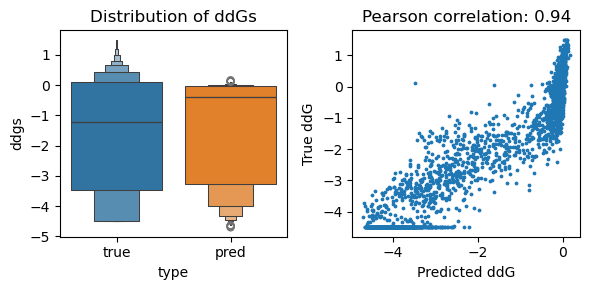

In [62]:
analyze_protein('5KPH')

  0%|          | 0/13 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


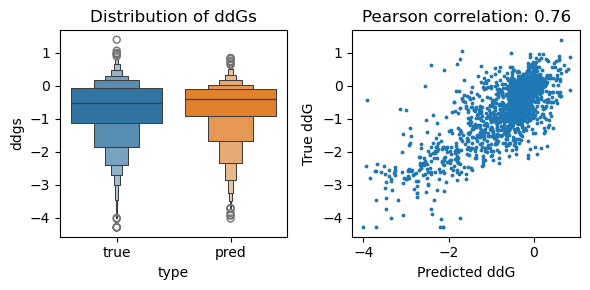

In [34]:
analyze_protein('2JT1')

  0%|          | 0/30 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


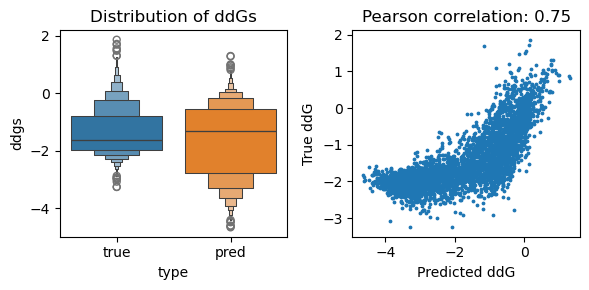

In [35]:
analyze_protein('6M3N')

  0%|          | 0/20 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


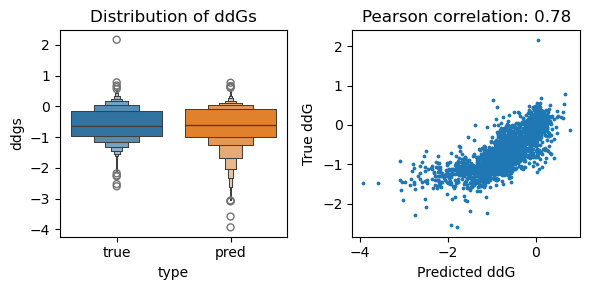

In [21]:
analyze_protein('2L9R') # WT_cluster=36

  0%|          | 0/30 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


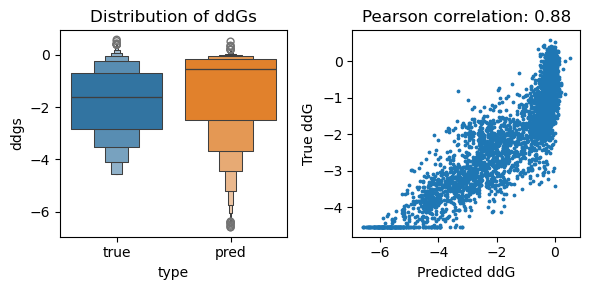

  0%|          | 0/13 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


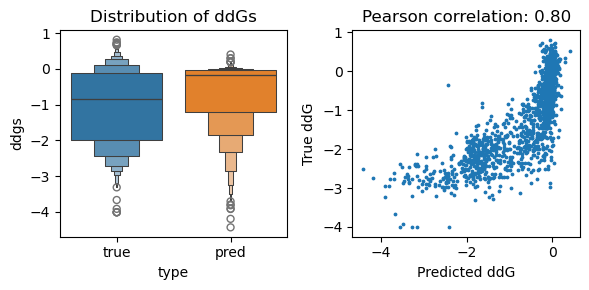

In [22]:
# WT_cluster=16
analyze_protein('3ZGK')
analyze_protein('2LC2')

### For Validation Sequences

In [17]:
dpo_valid_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_valid_dict.pkl'), 'rb'))
dpo_valid_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_valid_dict_wt.pkl'), 'rb'))

1ZHC


  0%|          | 0/13 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


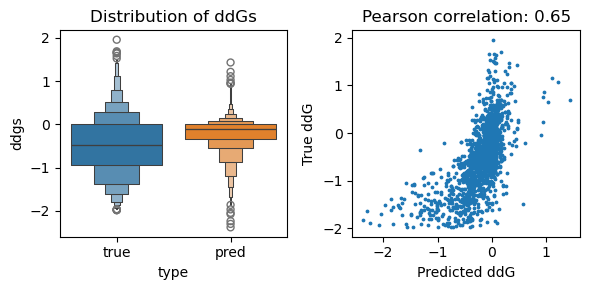

1UZC


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:05<00:00,  2.93it/s]


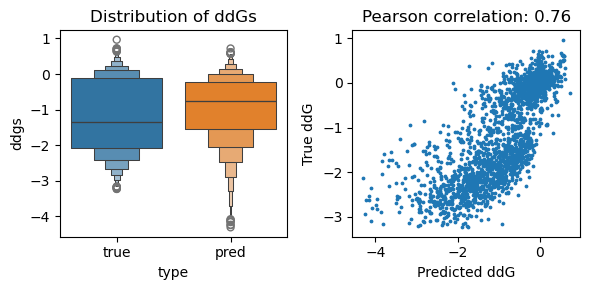

2LQK


  0%|          | 0/9 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


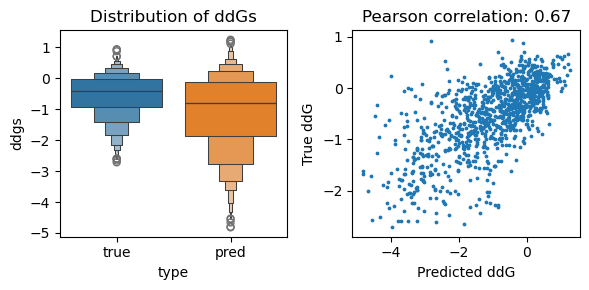

2MCK


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:02<00:00,  3.33it/s]


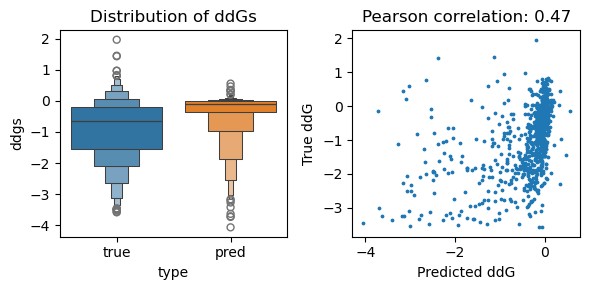

1JIC


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


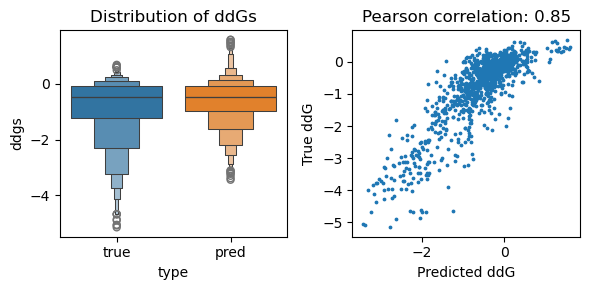

2WQG


  0%|          | 0/10 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


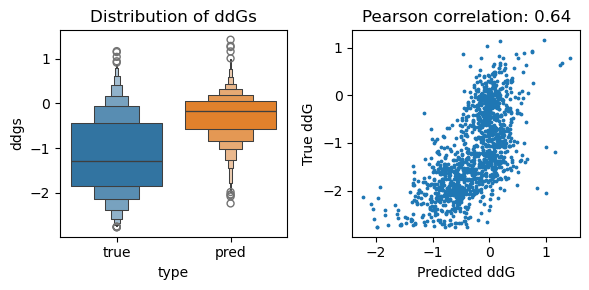

v2R31S|R32S_2N5D


  0%|          | 0/11 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 11/11 [00:03<00:00,  3.00it/s]


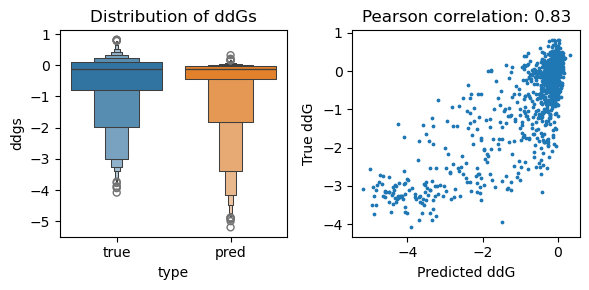

v2_4UZX


  0%|          | 0/9 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


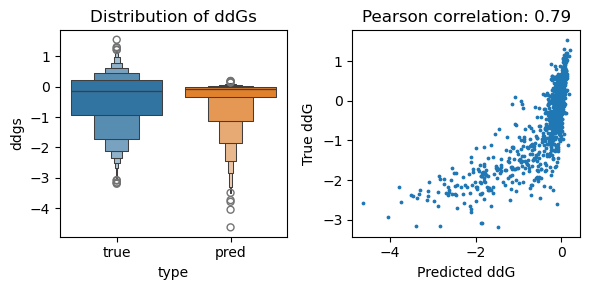

4UZW


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


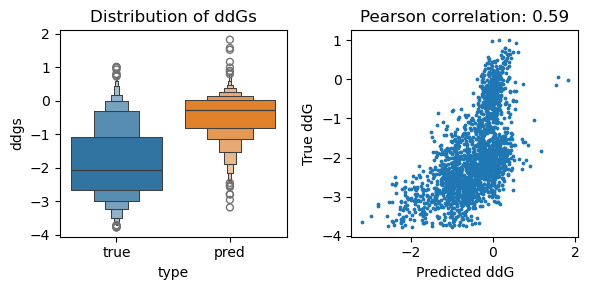

2MCH


  0%|          | 0/23 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 23/23 [00:07<00:00,  2.94it/s]


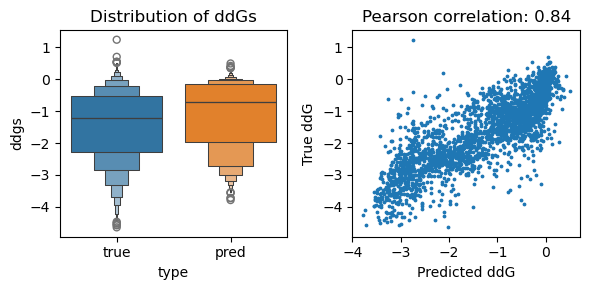

In [33]:
for name in dpo_valid_dict_wt.keys():
    print(name[:-4])
    analyze_protein(name[:-4], dpo_valid_dict)

### For Test Sequences

In [18]:
dpo_test_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_test_dict.pkl'), 'rb'))
dpo_test_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_test_dict_wt.pkl'), 'rb'))

EA|run5_0050_0004


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


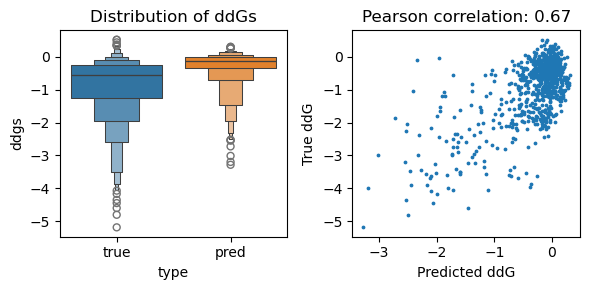

XX|run7_0974_0003


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


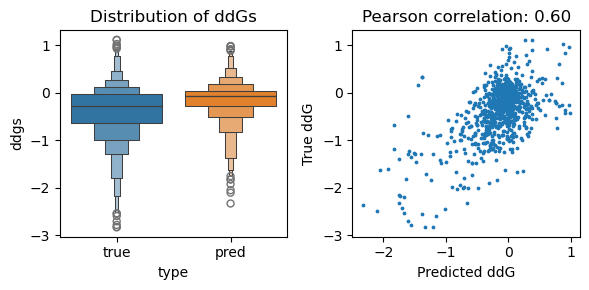

r6_560_TrROS_Hall


  0%|          | 0/9 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


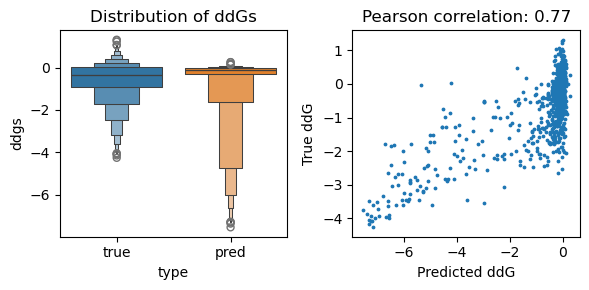

HEEH_KT_rd6_0746


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


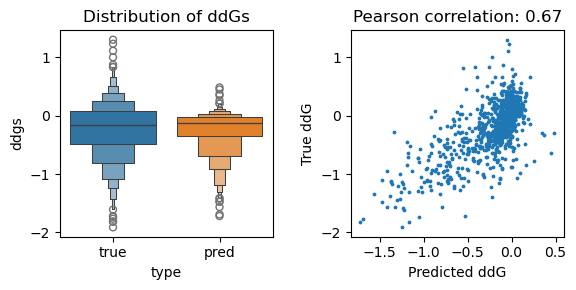

2M2J


  0%|          | 0/28 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


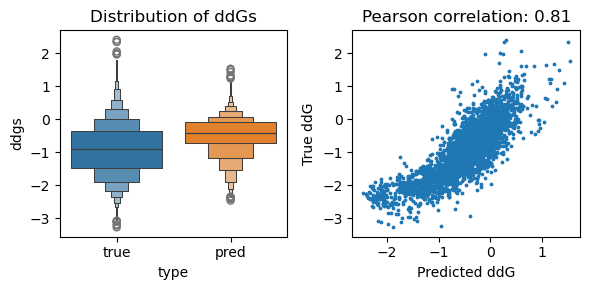

2MA4


  0%|          | 0/22 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


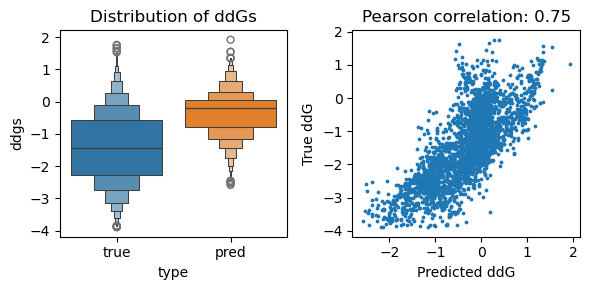

1F0M


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


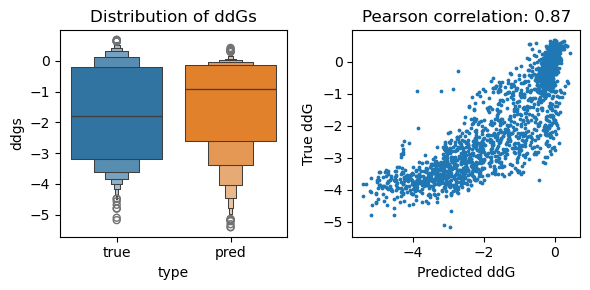

5JRT


  0%|          | 0/12 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


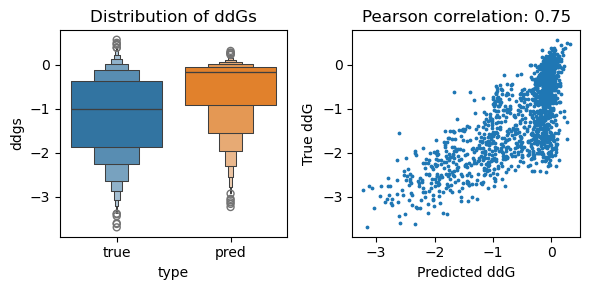

7JJK


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


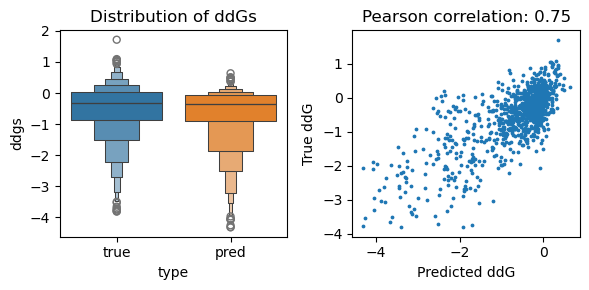

2KRU


  0%|          | 0/13 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


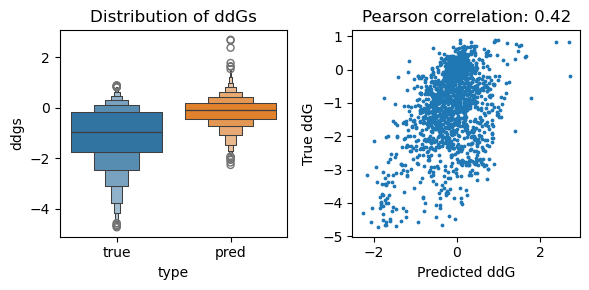

2L09


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:04<00:00,  3.85it/s]


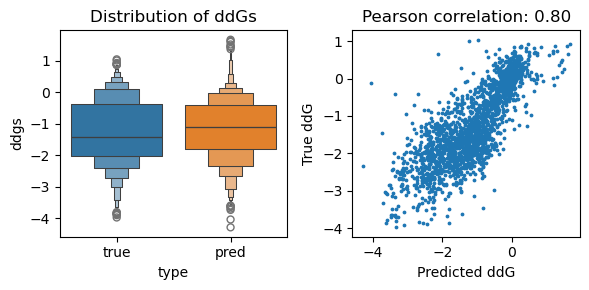

4G3O


  0%|          | 0/23 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 23/23 [00:05<00:00,  3.88it/s]


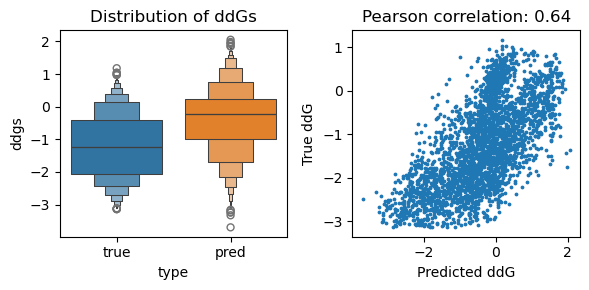

2LVN


  0%|          | 0/14 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 14/14 [00:03<00:00,  4.22it/s]


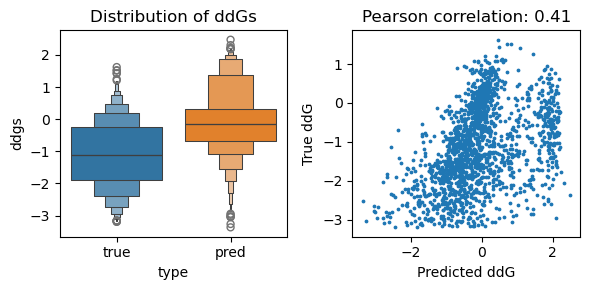

v2K43S_2KVV


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


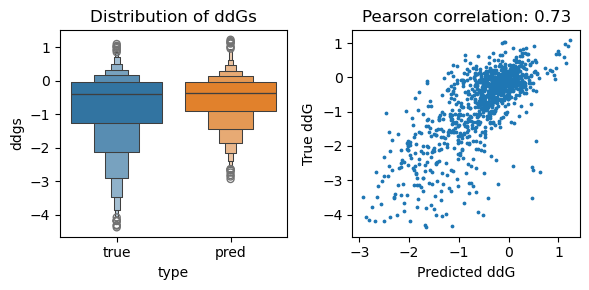

In [37]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    analyze_protein(name[:-4], dpo_test_dict)

EA|run5_0050_0004


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


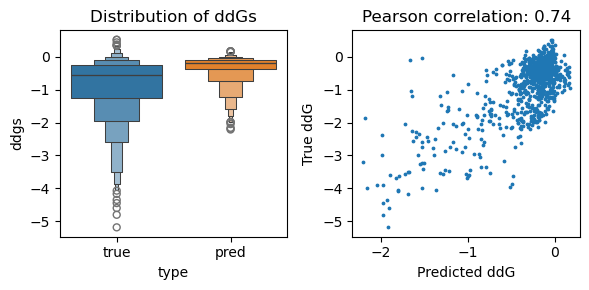

XX|run7_0974_0003


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


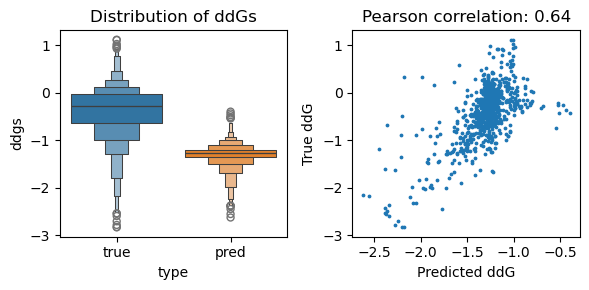

r6_560_TrROS_Hall


  0%|          | 0/9 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


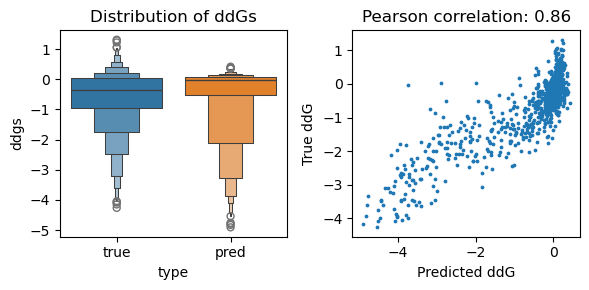

HEEH_KT_rd6_0746


  0%|          | 0/7 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


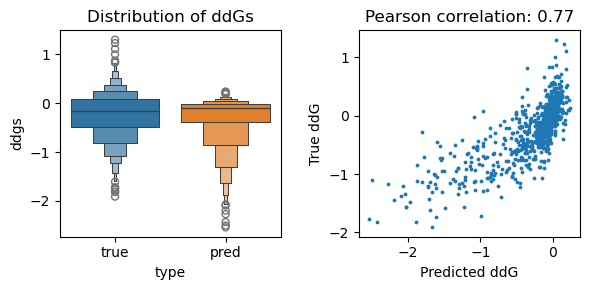

2M2J


  0%|          | 0/28 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 28/28 [00:04<00:00,  6.80it/s]


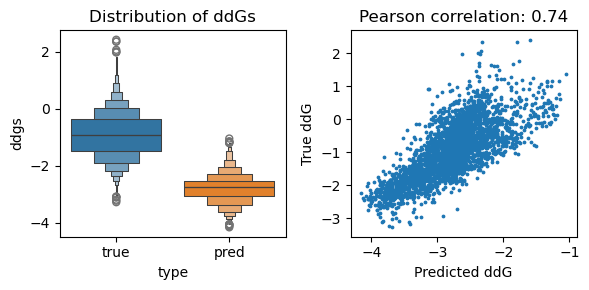

2MA4


  0%|          | 0/22 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 22/22 [00:02<00:00,  7.66it/s]


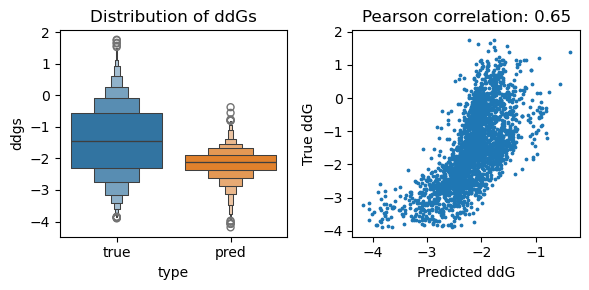

1F0M


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:01<00:00,  8.01it/s]


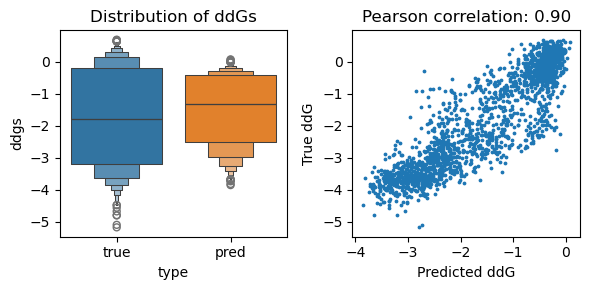

5JRT


  0%|          | 0/12 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


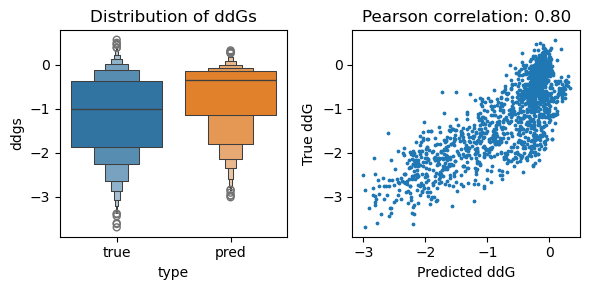

7JJK


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:00<00:00,  8.84it/s]


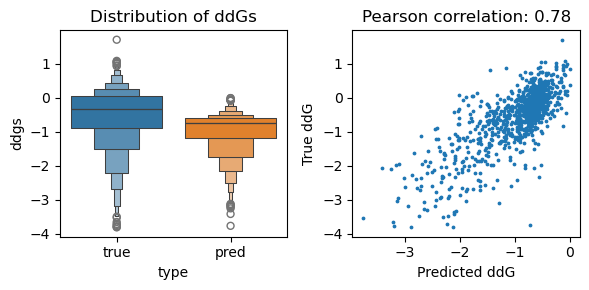

2KRU


  0%|          | 0/13 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 13/13 [00:01<00:00, 10.43it/s]


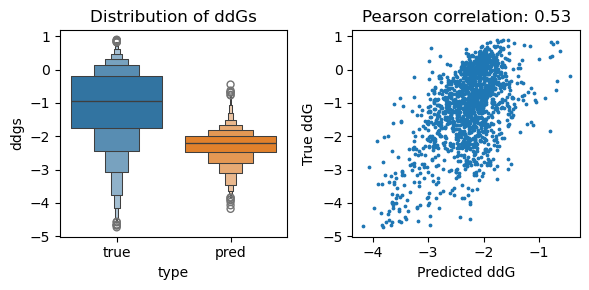

2L09


  0%|          | 0/16 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


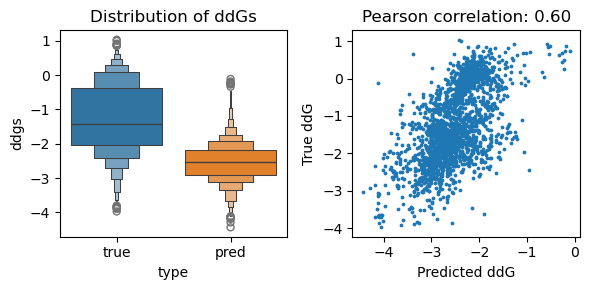

4G3O


  0%|          | 0/23 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 23/23 [00:02<00:00, 10.05it/s]


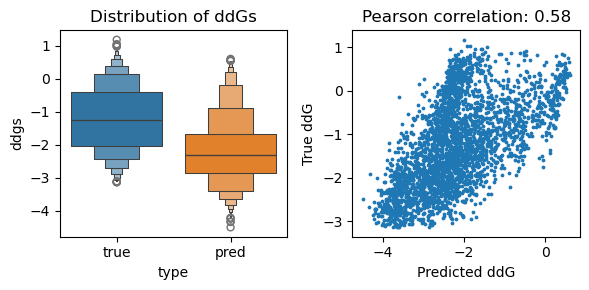

2LVN


  0%|          | 0/14 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 14/14 [00:01<00:00, 10.80it/s]


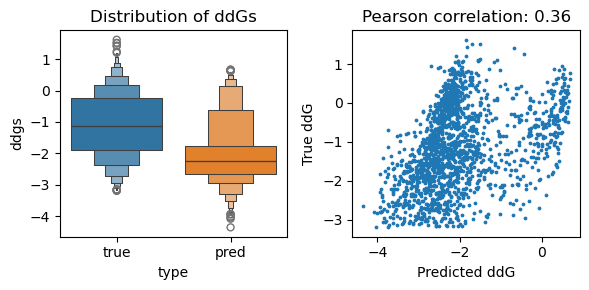

v2K43S_2KVV


  0%|          | 0/8 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


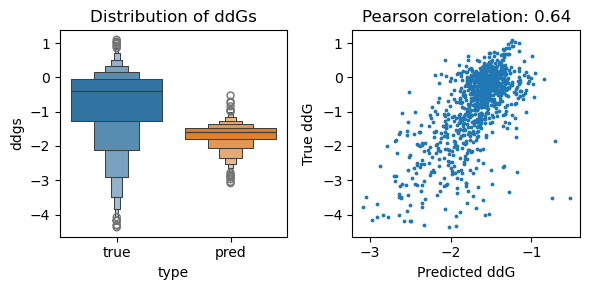

In [27]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    analyze_protein(name[:-4], dpo_test_dict, predict_ddg=True)

### For Generated Sequences

In [13]:
noise_interpolant = Interpolant(args)
noise_interpolant.set_device('cuda')

In [14]:
new_fmif_model = ProteinMPNNFMIF(node_features=args.hidden_dim,
                    edge_features=args.hidden_dim,
                    hidden_dim=args.hidden_dim,
                    num_encoder_layers=args.num_encoder_layers,
                    num_decoder_layers=args.num_encoder_layers,
                    k_neighbors=args.num_neighbors,
                    dropout=args.dropout,
                    # augment_eps=args.backbone_noise
                    )
new_fmif_model.to('cuda')
new_fmif_model.load_state_dict(torch.load('/data/wangc239/pmpnn/outputs/jnvGDJFmCj_20240710_145313/model_weights/epoch300_step447702.pt')['model_state_dict'])

<All keys matched successfully>

### For Generated Sequences (Training)

In [15]:
dpo_train_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict_wt.pkl'), 'rb'))

In [16]:
def sample_protein(name, dpo_dict_wt=dpo_train_dict_wt, predict_ddg=False):
    dpo_train_dict_wt_sub = {k: v for k, v in dpo_dict_wt.items() if v[-1] == f'{name}.pdb'}
    dpo_train_dataset_wt = ProteinDPODataset(dpo_train_dict_wt_sub, pdb_idx_dict, pdb_structures)
    loader_train_wt = DataLoader(dpo_train_dataset_wt, batch_size=1, shuffle=True)
    N_sample = 100
    pred_ddgs_pretrain = []
    new_fmif_model.eval()
    for batch in tqdm(loader_train_wt):
        X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, 'cuda')
        X = X.repeat(N_sample, 1, 1, 1)
        mask = mask.repeat(N_sample, 1)
        chain_M = chain_M.repeat(N_sample, 1)
        residue_idx = residue_idx.repeat(N_sample, 1)
        chain_encoding_all = chain_encoding_all.repeat(N_sample, 1)
        with torch.no_grad():
            S_sp, _, _ = noise_interpolant.sample(new_fmif_model, X, mask, chain_M, residue_idx, chain_encoding_all)
        # dg_ml = batch['dG_ML'].to(dtype=torch.float32, device=device)
        # dg_ml_wt = batch['dG_ML_wt'].to(dtype=torch.float32, device=device)
            # S_wt = S_wt.repeat(N_sample, 1)
            dg_pred = reward_model(X, S_sp, mask, chain_M, residue_idx, chain_encoding_all)
            dg_pred_wt = reward_model(X[[0]], S_wt, mask[[0]], chain_M[[0]], residue_idx[[0]], chain_encoding_all[[0]]).repeat(N_sample)
        if predict_ddg:
            pred_ddgs_pretrain.append(dg_pred.detach().cpu().numpy())
        else:
            pred_ddgs_pretrain.append((dg_pred - dg_pred_wt).detach().cpu().numpy())
    plot_data = pd.DataFrame({'ddgs': np.concatenate(pred_ddgs_pretrain), 'type': ['train']*np.concatenate(pred_ddgs_pretrain).shape[0]})
    fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen", height=3, aspect=1)
    if predict_ddg:
        fig.fig.suptitle(f'ddG_wt_pred: {dg_pred_wt[0]:.2f}')
    else:
        dgwt = batch['dG_ML_wt'][0]
        fig.fig.suptitle(f'dG_wt: {dgwt:.2f}, dG_wt_pred: {dg_pred_wt[0]:.2f}')
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


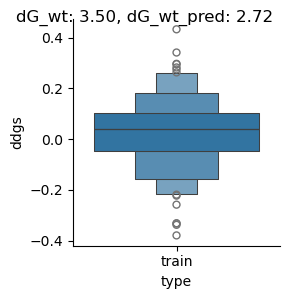

In [53]:
sample_protein('5KPH')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


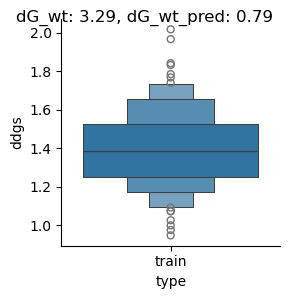

In [54]:
sample_protein('2JT1')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.02s/it]


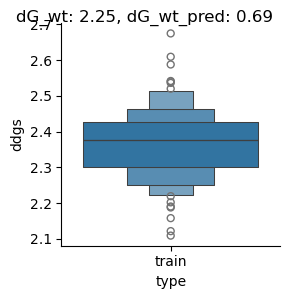

In [55]:
sample_protein('6M3N')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


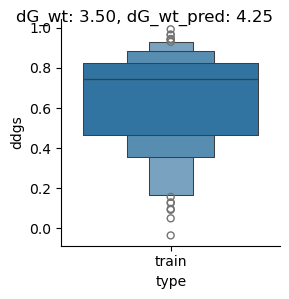

In [82]:
sample_protein('5KPH')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


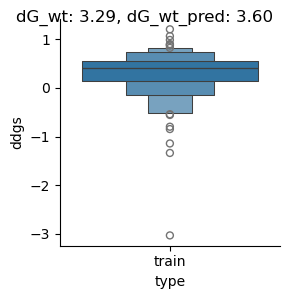

In [83]:
sample_protein('2JT1')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


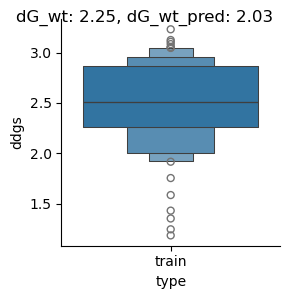

In [84]:
sample_protein('6M3N')

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


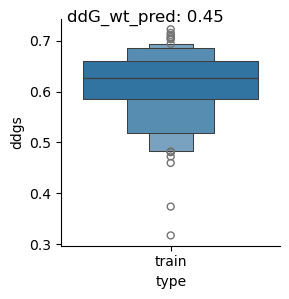

In [19]:
sample_protein('5KPH', predict_ddg=True)

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


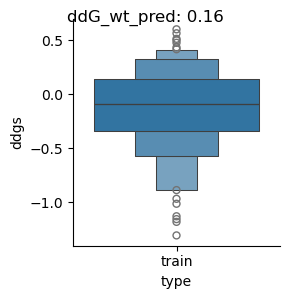

In [20]:
sample_protein('2JT1', predict_ddg=True)

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


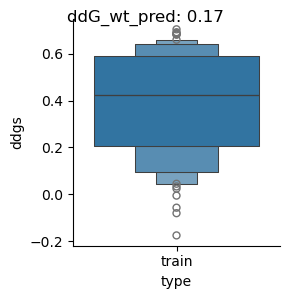

In [21]:
sample_protein('6M3N', predict_ddg=True)

### For Generated Sequences (Validation)

1ZHC


100%|██████████| 1/1 [00:06<00:00,  6.21s/it]


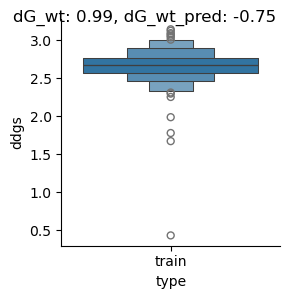

1UZC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


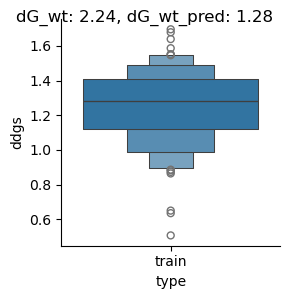

2LQK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


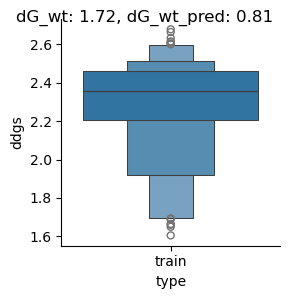

2MCK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.79s/it]


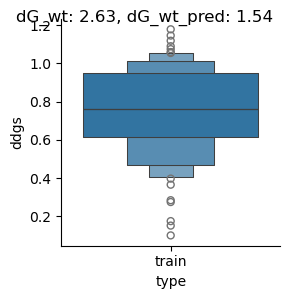

1JIC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


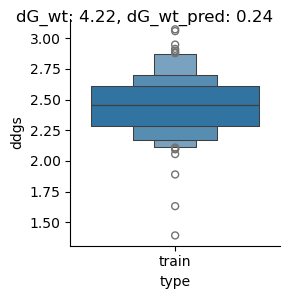

2WQG


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


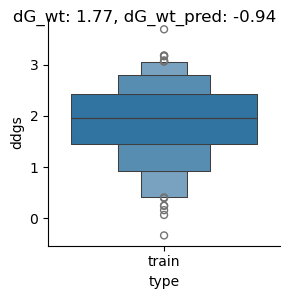

v2R31S|R32S_2N5D


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


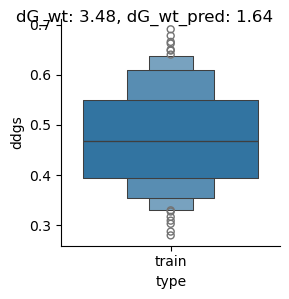

v2_4UZX


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.48s/it]


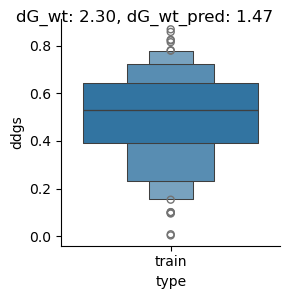

4UZW


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


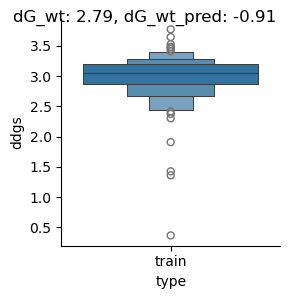

2MCH


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


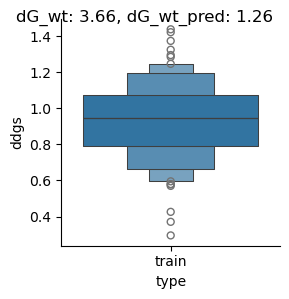

In [58]:
for name in dpo_valid_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_valid_dict_wt)

1ZHC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


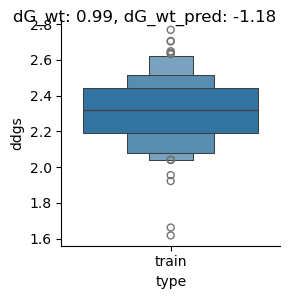

1UZC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


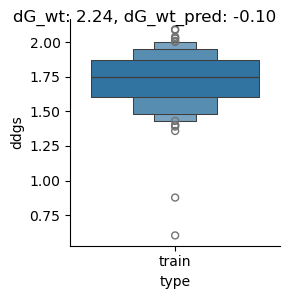

2LQK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


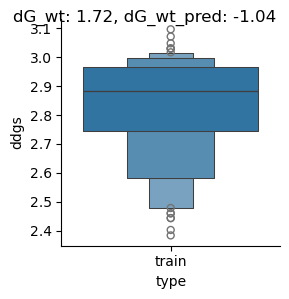

2MCK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


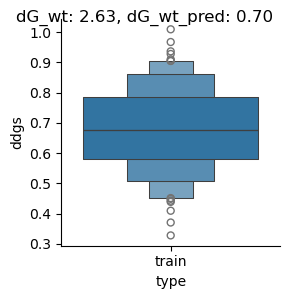

1JIC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


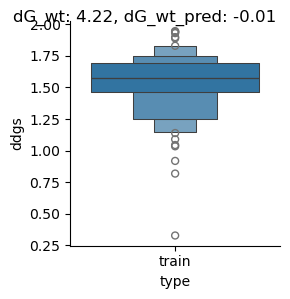

2WQG


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


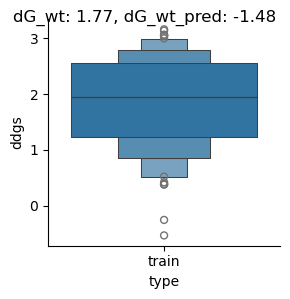

v2R31S|R32S_2N5D


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


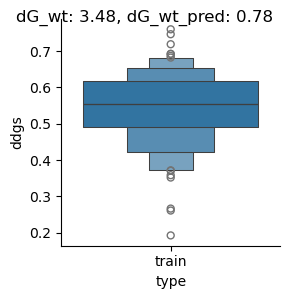

v2_4UZX


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


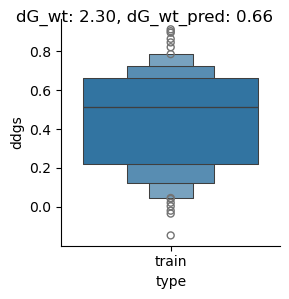

4UZW


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


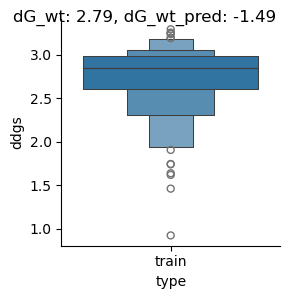

2MCH


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


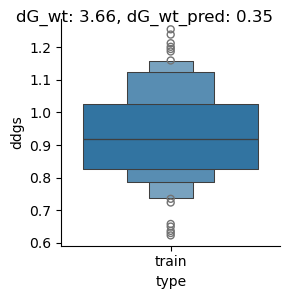

In [65]:
for name in dpo_valid_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_valid_dict_wt)

1ZHC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


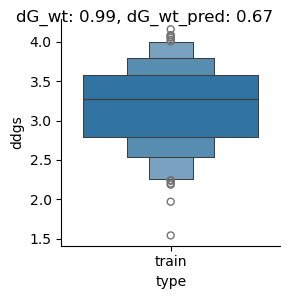

1UZC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


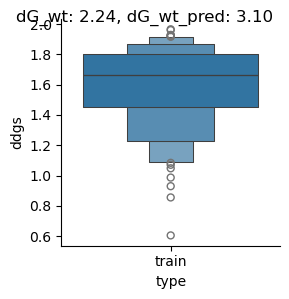

2LQK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


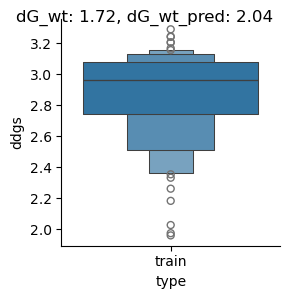

2MCK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


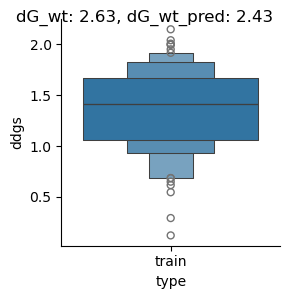

1JIC


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


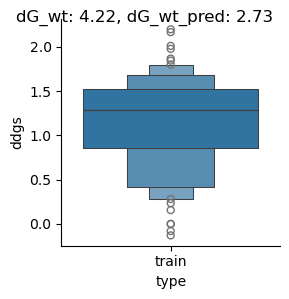

2WQG


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


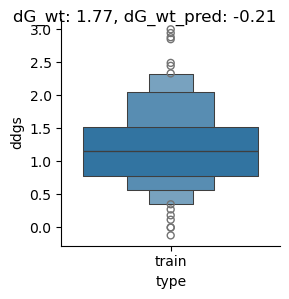

v2R31S|R32S_2N5D


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


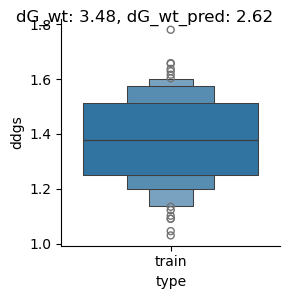

v2_4UZX


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


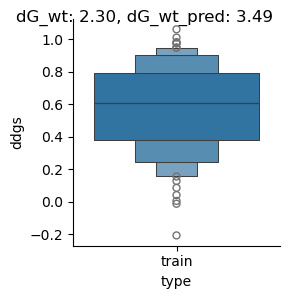

4UZW


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


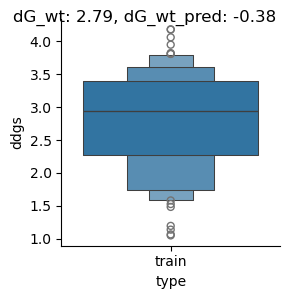

2MCH


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


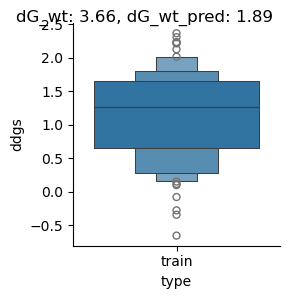

In [68]:
for name in dpo_valid_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_valid_dict_wt)

### For Generated Sequences (Test)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


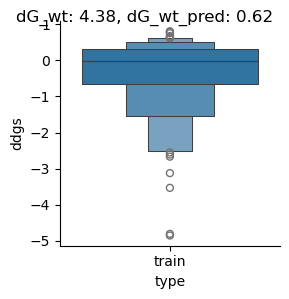

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


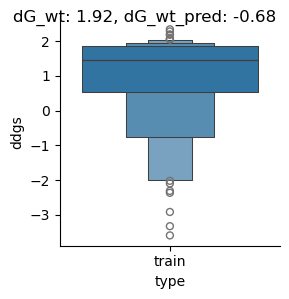

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


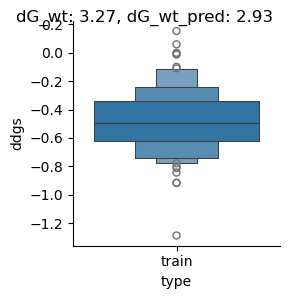

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


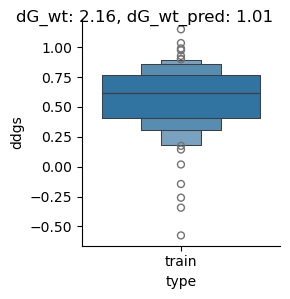

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


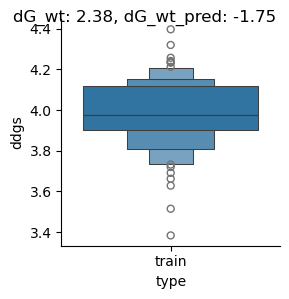

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


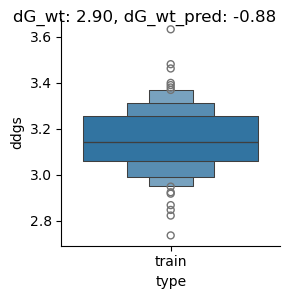

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


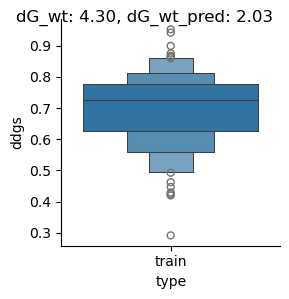

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


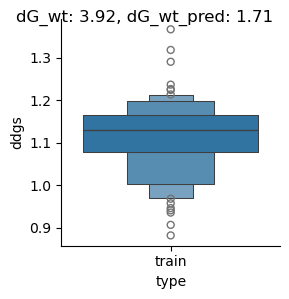

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


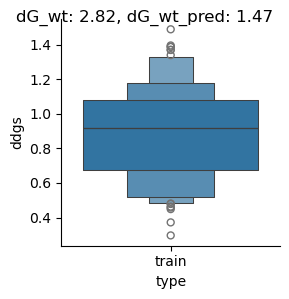

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


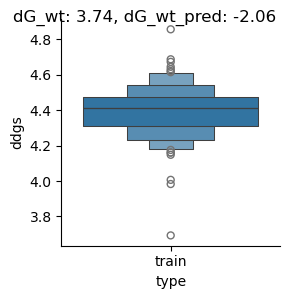

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


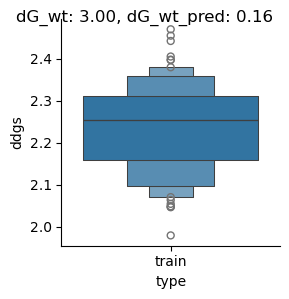

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


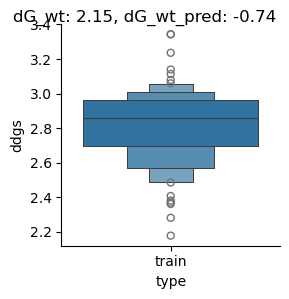

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


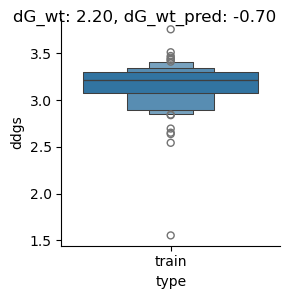

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


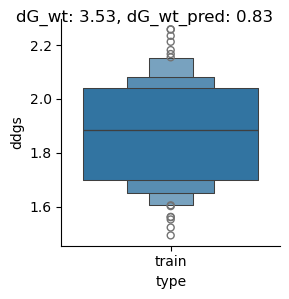

In [59]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


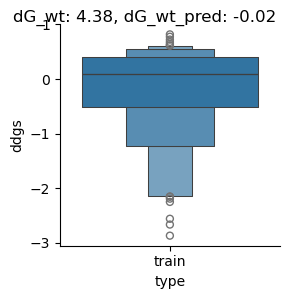

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


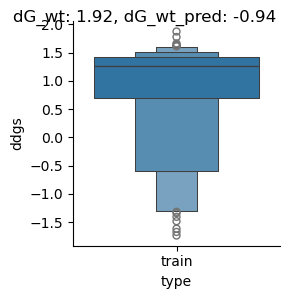

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


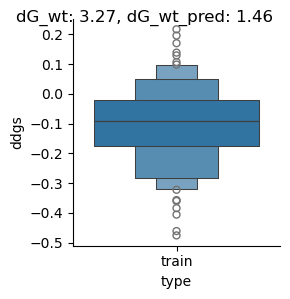

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


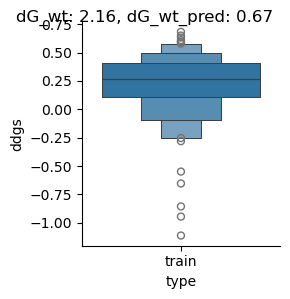

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


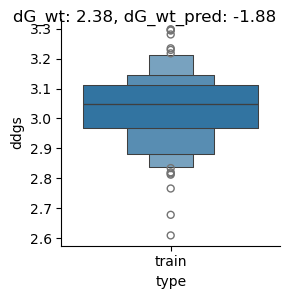

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


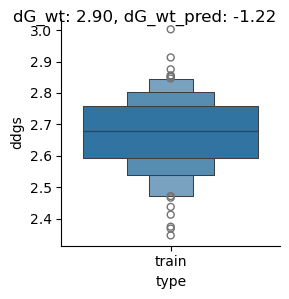

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


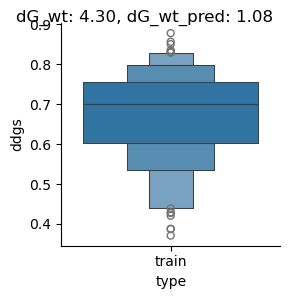

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


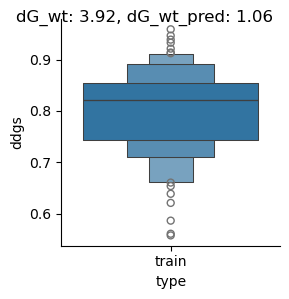

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


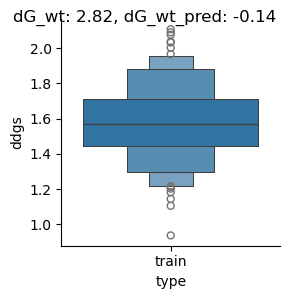

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


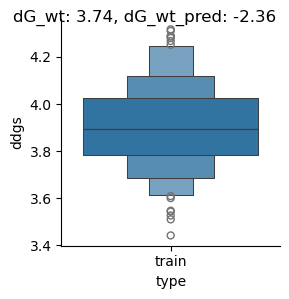

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


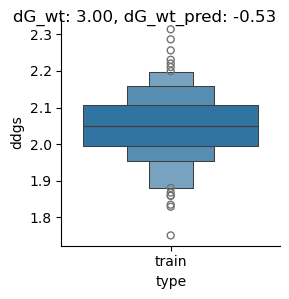

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


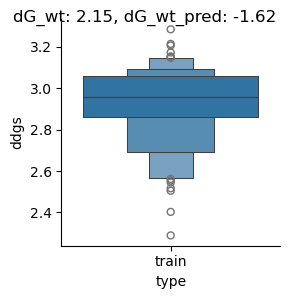

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


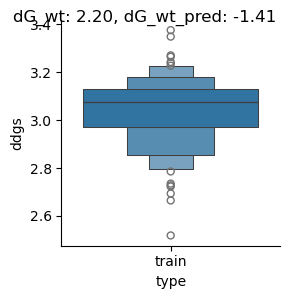

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


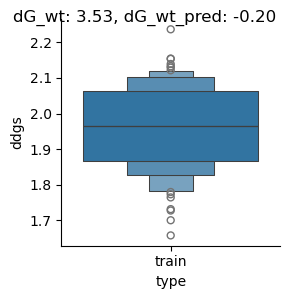

In [66]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


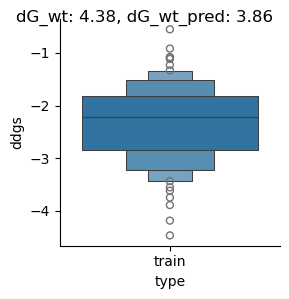

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


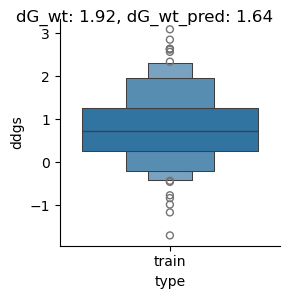

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


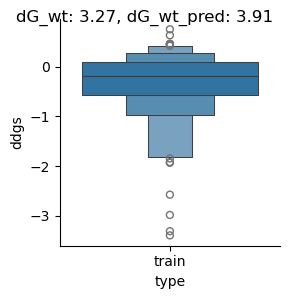

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


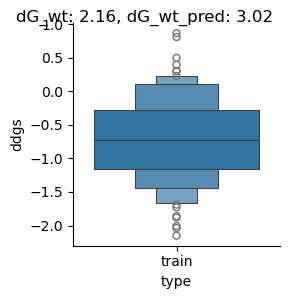

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


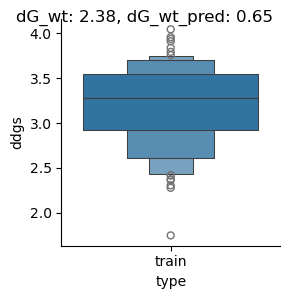

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


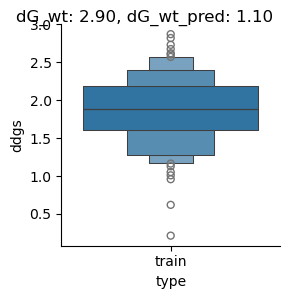

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


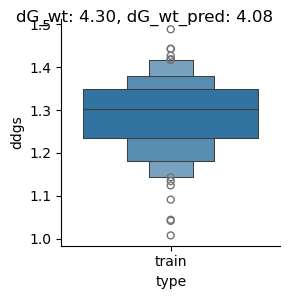

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


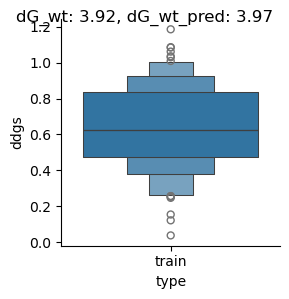

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


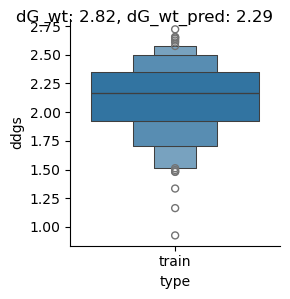

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


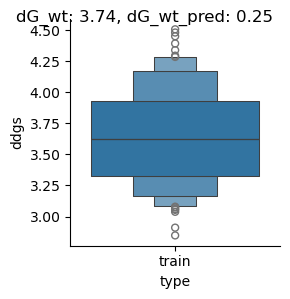

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


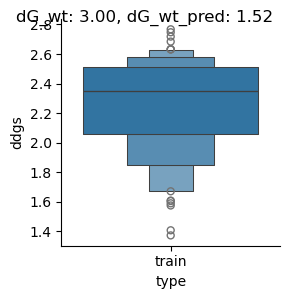

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


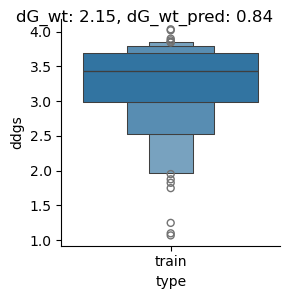

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


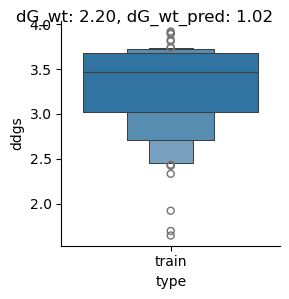

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


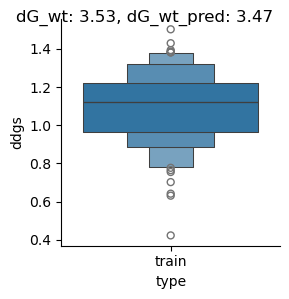

In [69]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


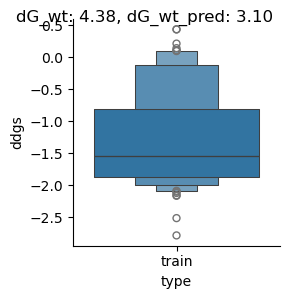

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


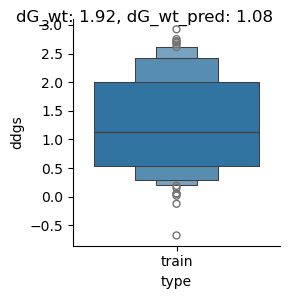

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.43s/it]


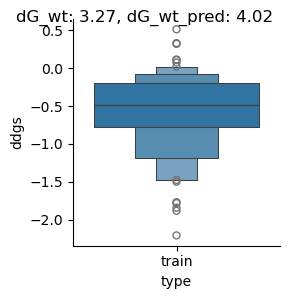

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


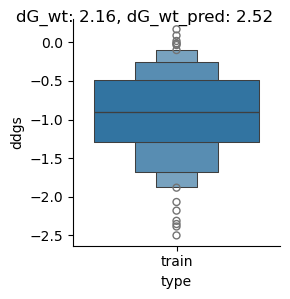

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


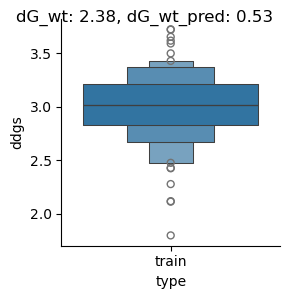

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


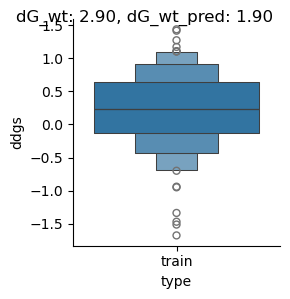

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


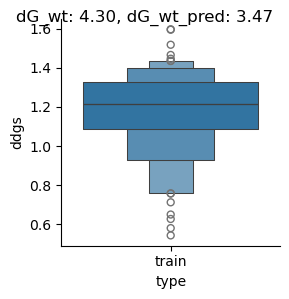

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


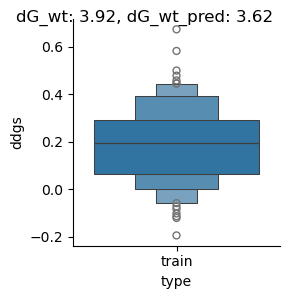

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.43s/it]


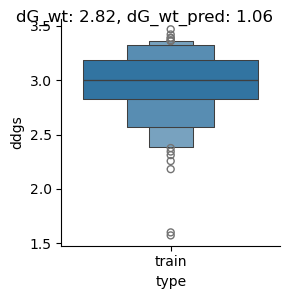

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


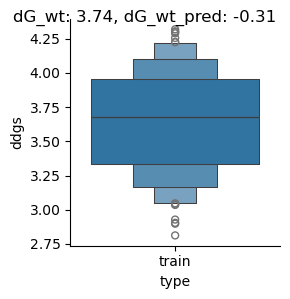

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


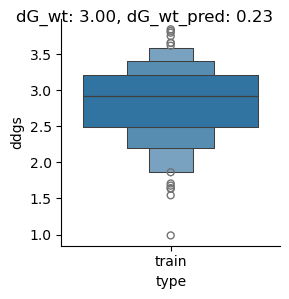

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


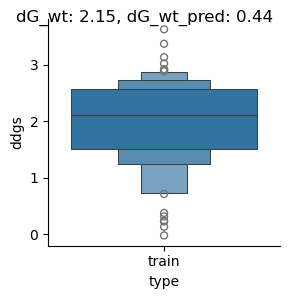

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


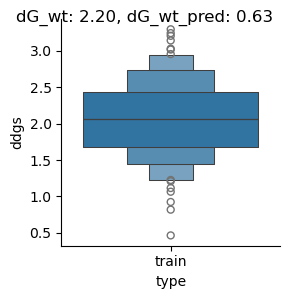

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


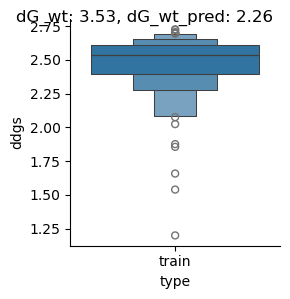

In [71]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


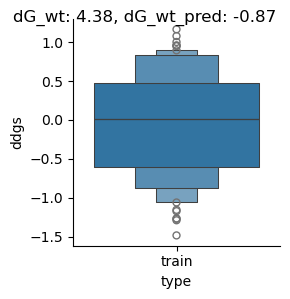

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


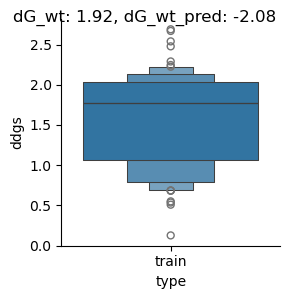

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


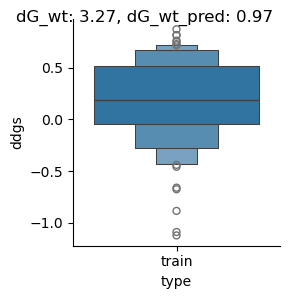

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


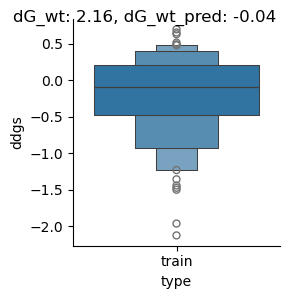

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


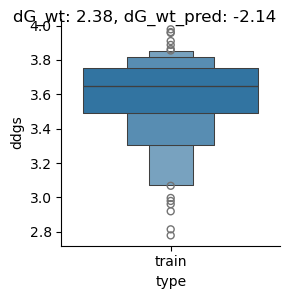

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


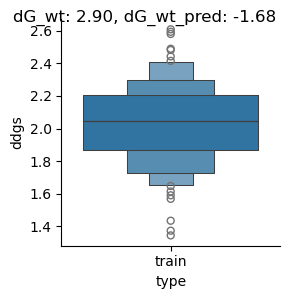

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


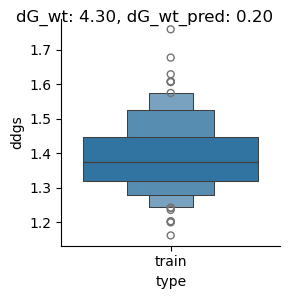

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


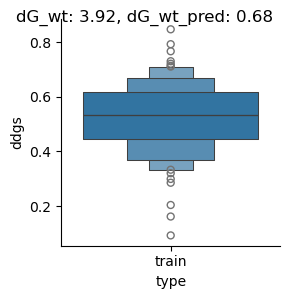

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


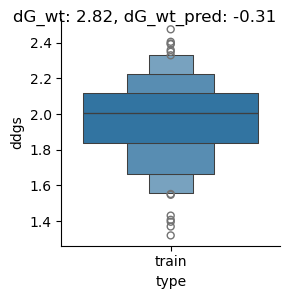

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


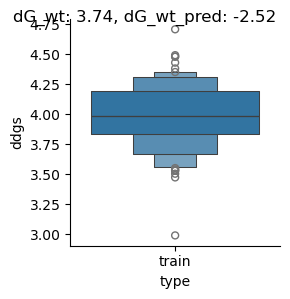

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


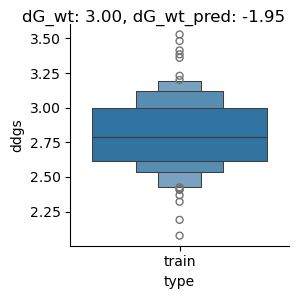

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


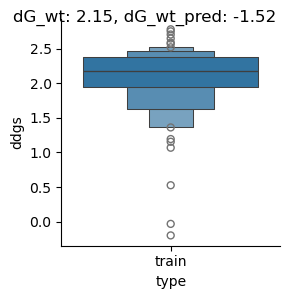

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


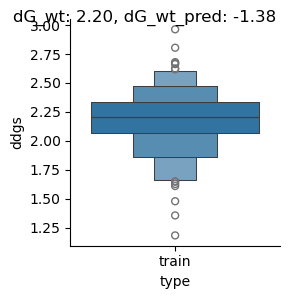

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


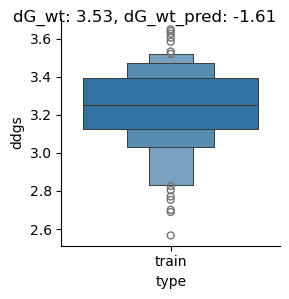

In [73]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


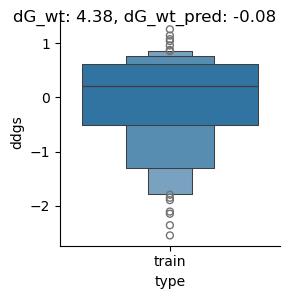

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


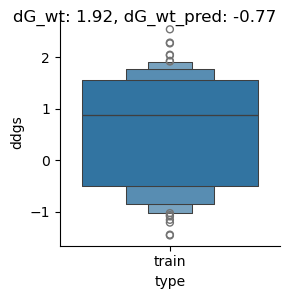

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


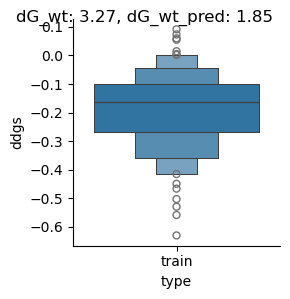

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


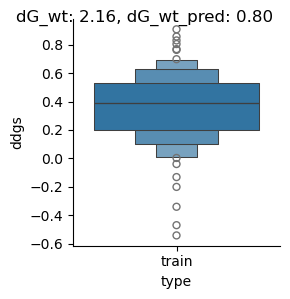

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


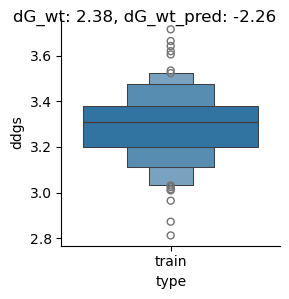

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


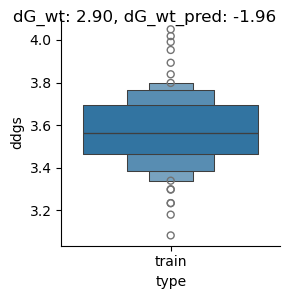

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


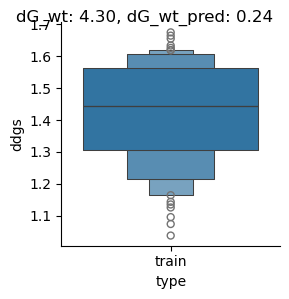

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


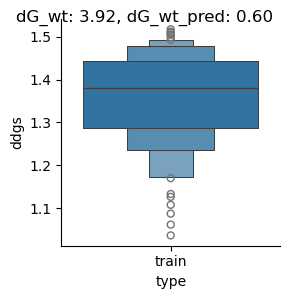

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


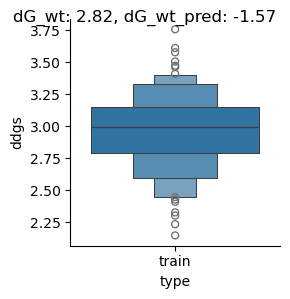

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


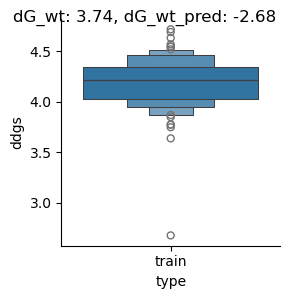

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


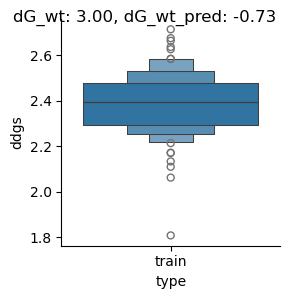

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


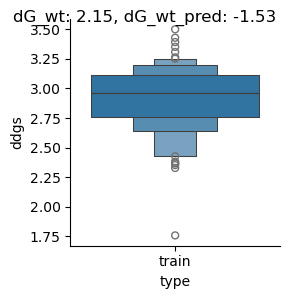

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


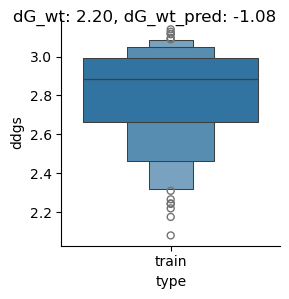

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


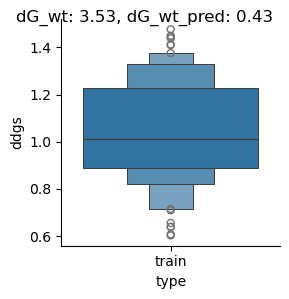

In [75]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


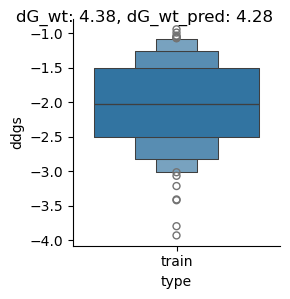

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


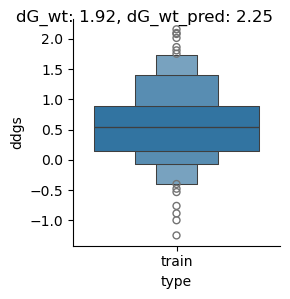

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


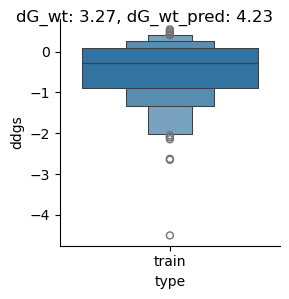

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


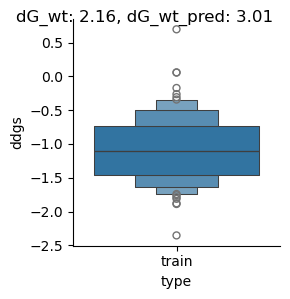

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


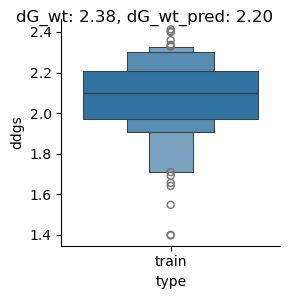

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


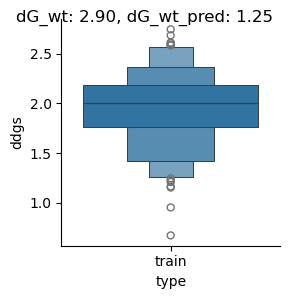

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


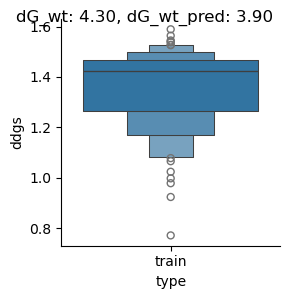

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


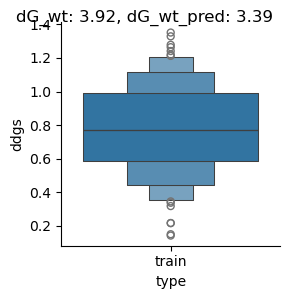

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


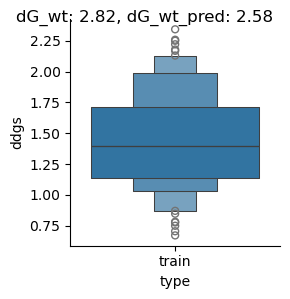

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


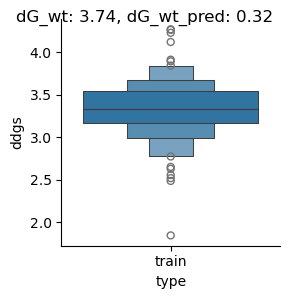

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


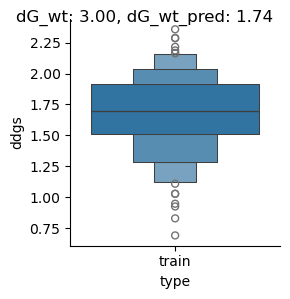

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


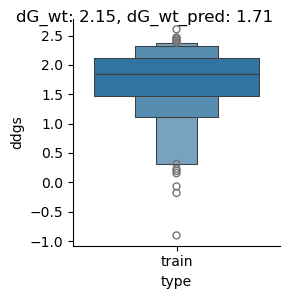

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


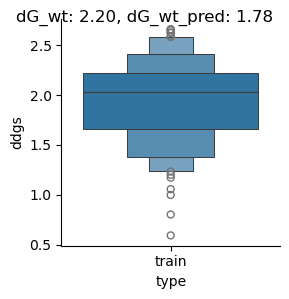

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


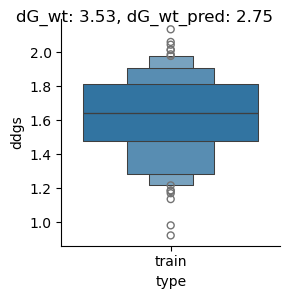

In [77]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


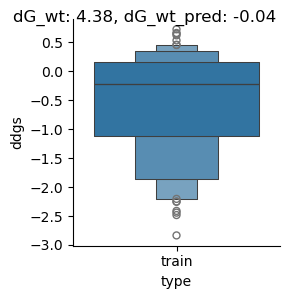

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


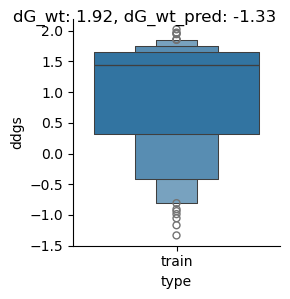

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


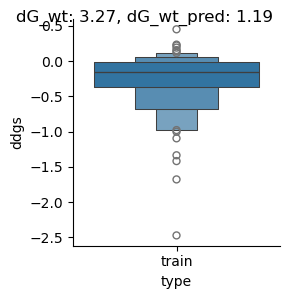

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


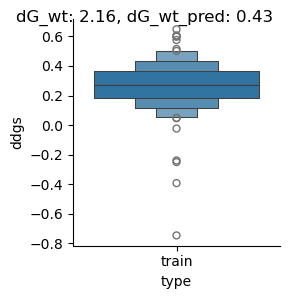

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


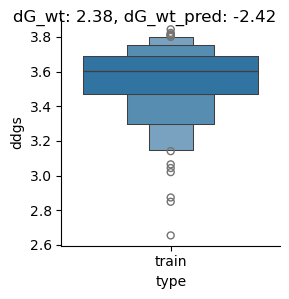

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


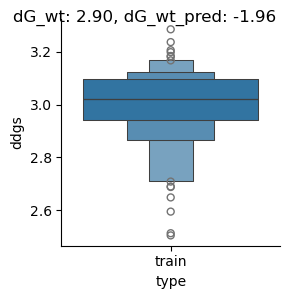

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


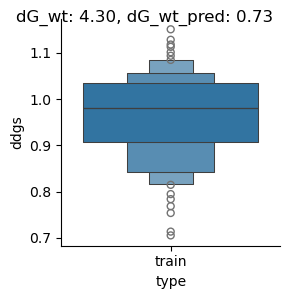

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


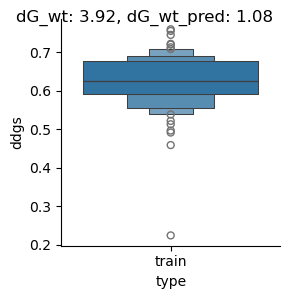

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


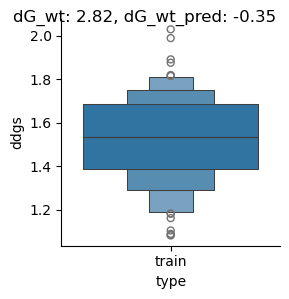

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


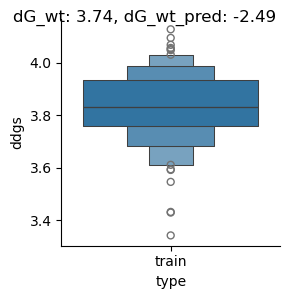

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


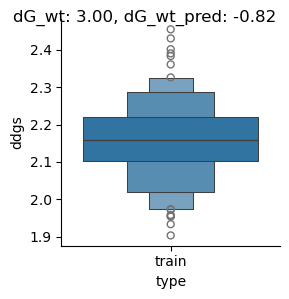

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


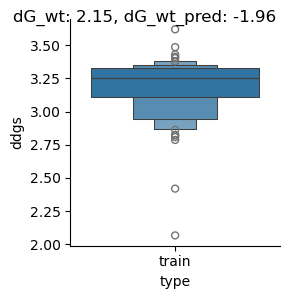

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


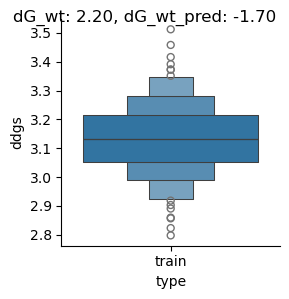

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


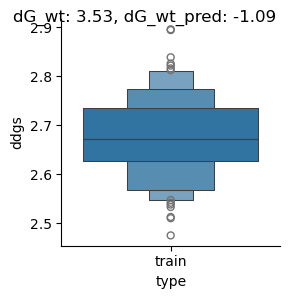

In [79]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


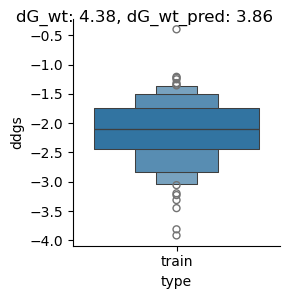

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


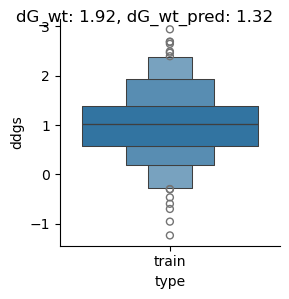

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


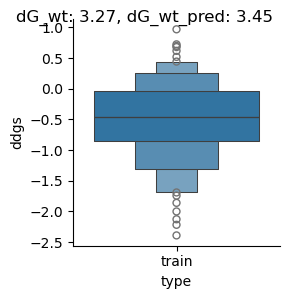

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


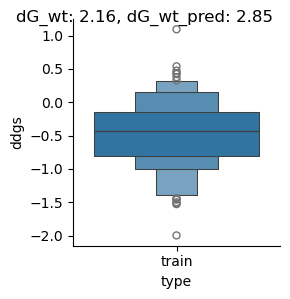

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


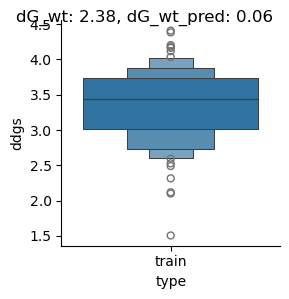

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


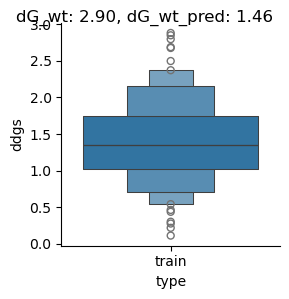

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


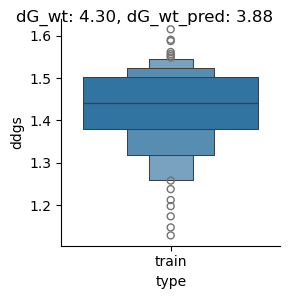

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


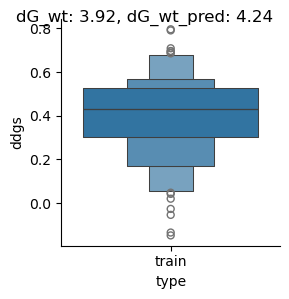

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


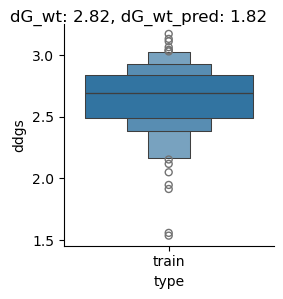

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


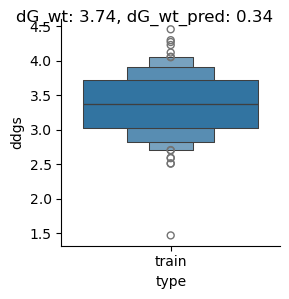

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


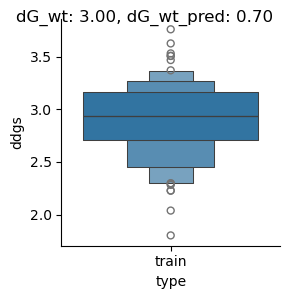

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


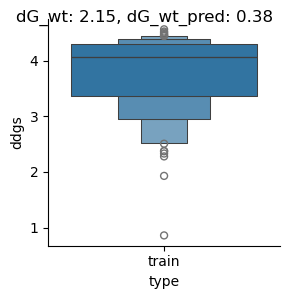

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


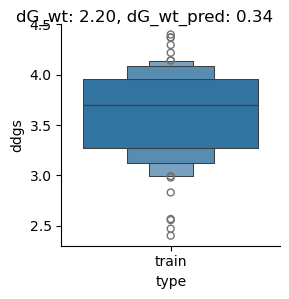

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


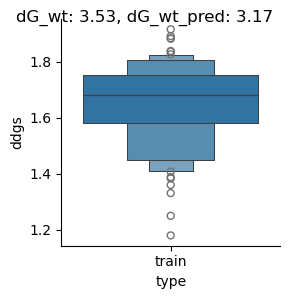

In [81]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


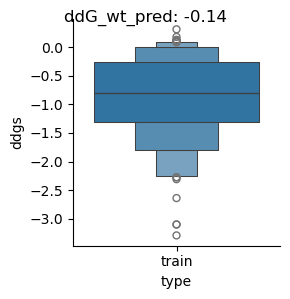

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


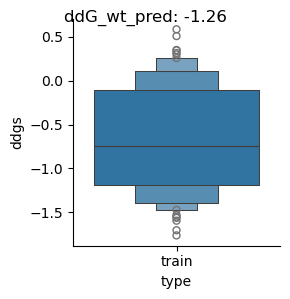

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


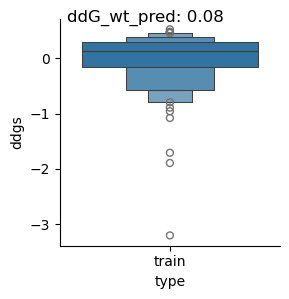

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


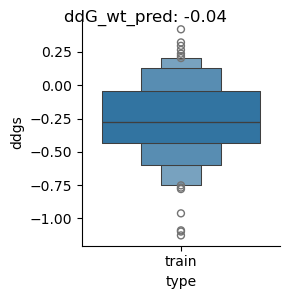

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


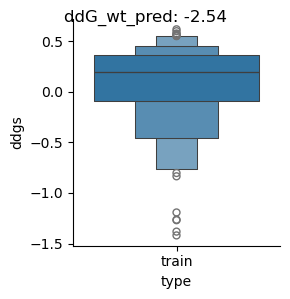

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


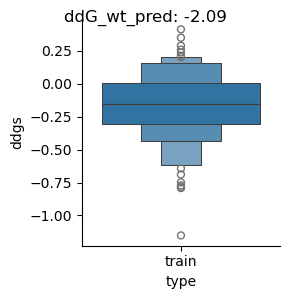

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


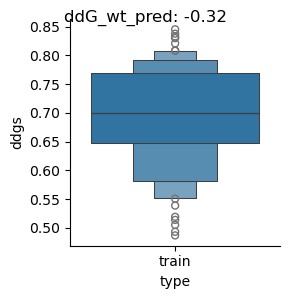

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


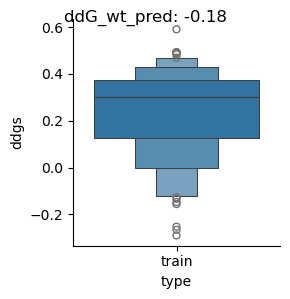

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


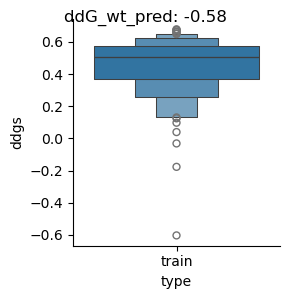

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


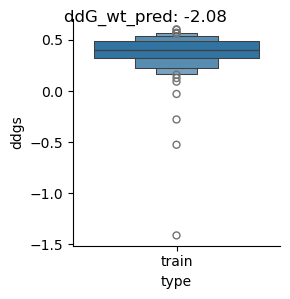

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


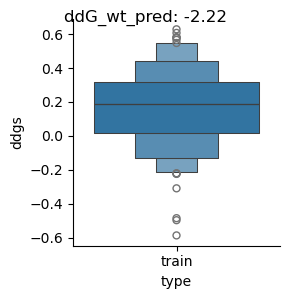

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


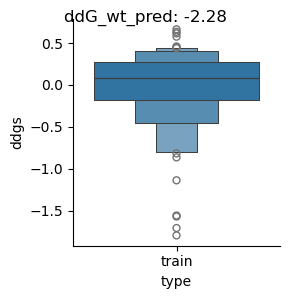

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


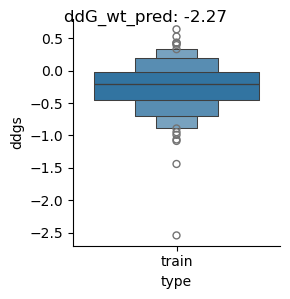

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


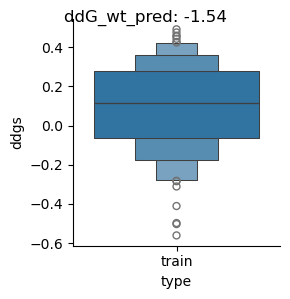

In [22]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt, predict_ddg=True)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


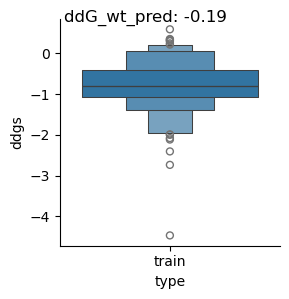

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


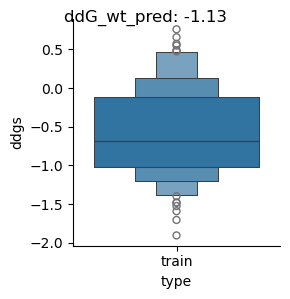

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


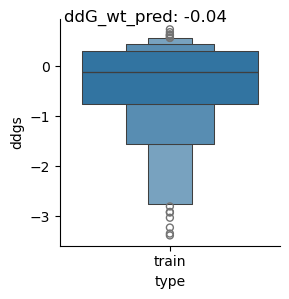

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


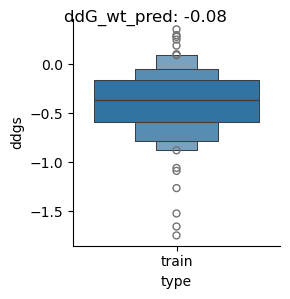

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


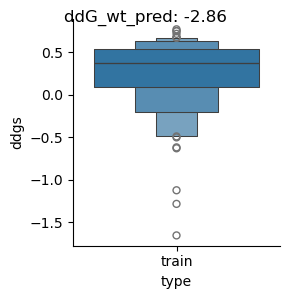

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


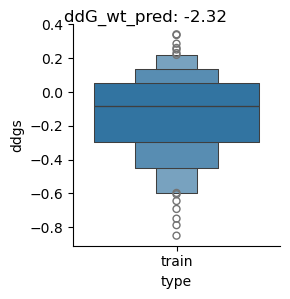

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


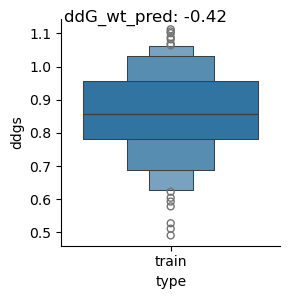

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


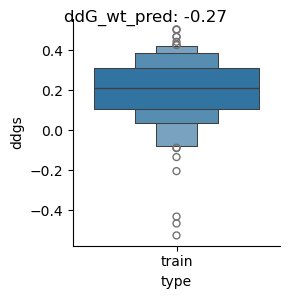

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


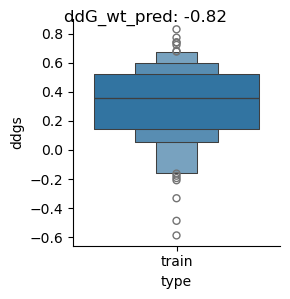

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


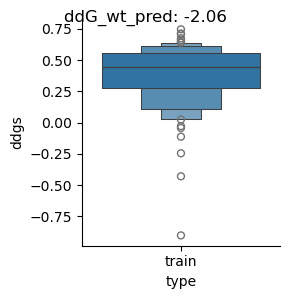

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


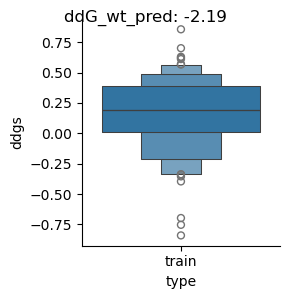

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


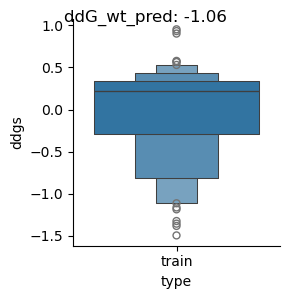

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


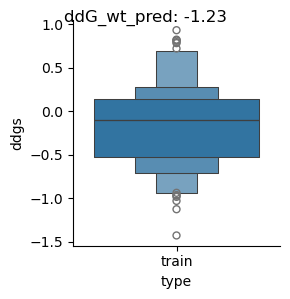

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


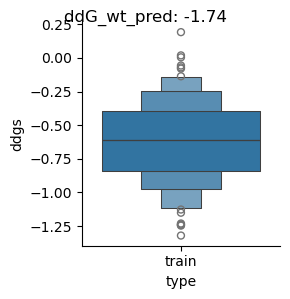

In [19]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt, predict_ddg=True)

EA|run5_0050_0004


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


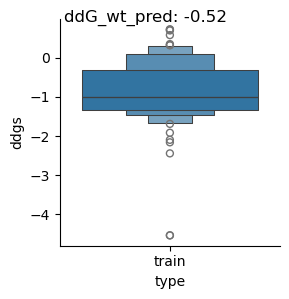

XX|run7_0974_0003


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


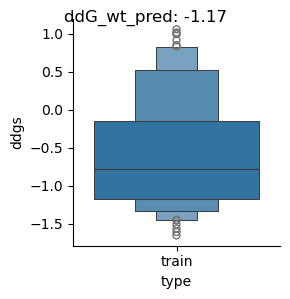

r6_560_TrROS_Hall


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


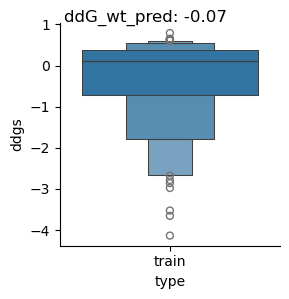

HEEH_KT_rd6_0746


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


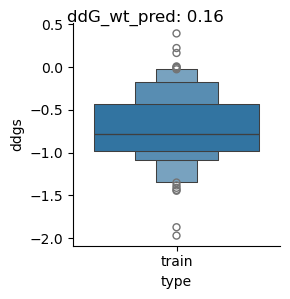

2M2J


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


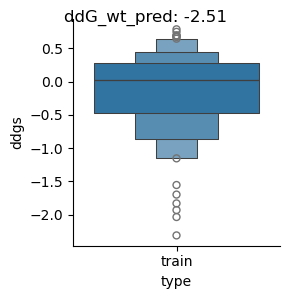

2MA4


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


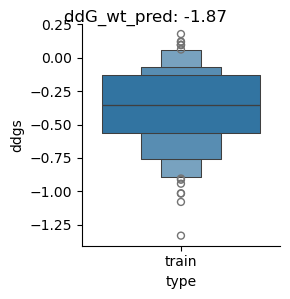

1F0M


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


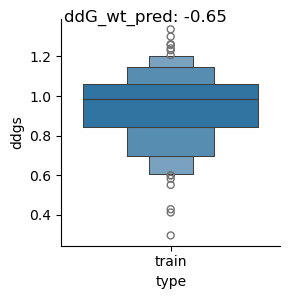

5JRT


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


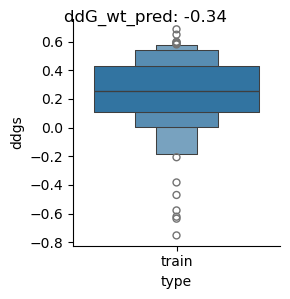

7JJK


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


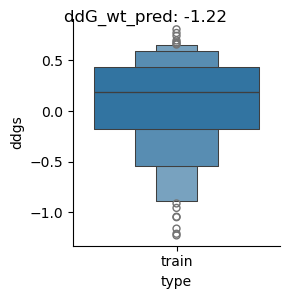

2KRU


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


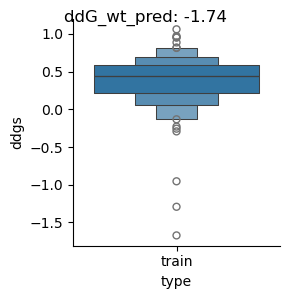

2L09


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


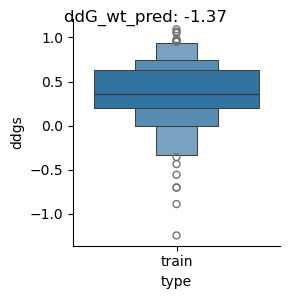

4G3O


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


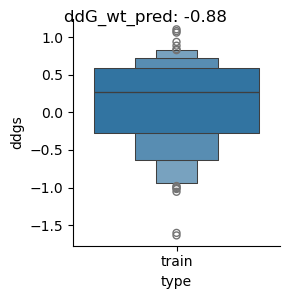

2LVN


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


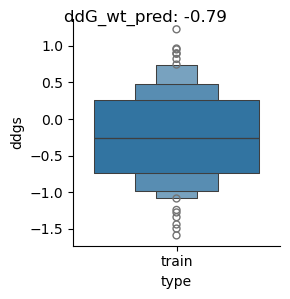

v2K43S_2KVV


  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


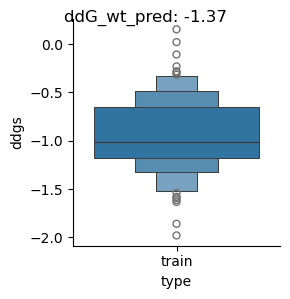

In [21]:
for name in dpo_test_dict_wt.keys():
    print(name[:-4])
    sample_protein(name[:-4], dpo_test_dict_wt, predict_ddg=True)